# BTC Predictor

In [213]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [271]:
import json as js
import numpy as np
import pandas as pd
from ta import *
#from fastai.structured import *
#from fastai.column_data import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_train_validation(self, testRecordsCount, trainRecordsCount):
        self.test = self.train.tail(testRecordsCount)
        self.train = self.train.head(trainRecordsCount)
#        self.test.reset_index(inplace=True)
#        self.train.reset_index(inplace=True)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['maxc5'] = self.get_max_lookback("Close", 5)
        self.train['maxc15'] = self.get_max_lookback("Close", 15)
        self.train['maxc30'] = self.get_max_lookback("Close", 30)
        self.train['maxc60'] = self.get_max_lookback("Close", 60)
        self.train['maxc90'] = self.get_max_lookback("Close", 90)
        self.train['maxh5'] = self.get_max_lookback("High", 5)
        self.train['maxh15'] = self.get_max_lookback("High", 15)
        self.train['maxh30'] = self.get_max_lookback("High", 30)
        self.train['maxh60'] = self.get_max_lookback("High", 60)
        self.train['maxh90'] = self.get_max_lookback("High", 90)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.train['minc5'] = self.get_min_lookback("Close", 5)
        self.train['minc15'] = self.get_min_lookback("Close", 15)
        self.train['minc30'] = self.get_min_lookback("Close", 30)
        self.train['minc60'] = self.get_min_lookback("Close", 60)
        self.train['minc90'] = self.get_min_lookback("Close", 90)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(np.float32)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [215]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

In [216]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 15
percentIncrease = 1.002
recordsCount      = 110000
trainRecordsCount = 100000
testRecordsCount  = 10000
trainRatio = 0.9
lr = 1e-4
dropout = 0.01
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [217]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [218]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [219]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [220]:
train= tables[0]

In [221]:
train = train.head(1500000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 110000 Original size: 1500000


## Data Cleaning

In [222]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close
1390000,2017-09-02 00:47:00,4.000356,4944.76,4944.77,4944.71,4944.71
1390001,2017-09-02 00:48:00,24.264185,4944.71,4944.71,4934.98,4935.38
1390002,2017-09-02 00:49:00,10.139276,4935.38,4940.63,4932.43,4938.01
1390003,2017-09-02 00:50:00,4.131629,4938.01,4938.01,4938.01,4938.01
1390004,2017-09-02 00:51:00,4.422197,4938.01,4938.01,4938.00,4938.00


## Join Bitstamp

In [223]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [224]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [225]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 39883 Sell count: 70117


In [226]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:607: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:629: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


Train size: 110000


In [227]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 109800


## Split validation and test sets

In [228]:
p.split_train_validation(testRecordsCount, trainRecordsCount)

Train size: 100000 Test size: 10000


In [229]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,action,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1390100,2017-09-02 02:27:00,7.099784,4973.89,4973.89,4973.88,4973.89,0,11.187363,0.000000,-4.538747,0.556178,-0.000000,-0.007957,0.000000,1001.413674,1.020797,4984.452616,4969.062384,4976.7575,0.0,0.0,4978.320667,4979.079667,4977.561667,0.0,0.0,4980.0,4966.69,0.0,0.0,2.977292,4.406973,-1.429681,4976.638195,4973.660902,67.676608,39.651071,59.397304,0,0.912768,1.088025,0.175258,0.013171,20.522990,-46.159915,3.2425,2.929028,3.596031,-0.667002,4960.9050,4952.405,52.0,12.0,40.0,27.406557,39.204122,42.693505,35.141730,18.096515,18.096515,-81.903485,3.876147,0.000000,0.000000,0.590126,4980.00,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4976.334,4978.276000,4973.547667,4961.334333,4953.794000,4973.89,4973.89,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319220,2,27
1390101,2017-09-02 02:28:00,5.931862,4973.89,4973.89,4973.88,4973.89,0,13.031645,0.000000,-4.538747,0.559484,0.000000,-0.037352,0.000000,1001.413674,0.886024,4983.367492,4970.867508,4977.1175,0.0,0.0,4977.709667,4978.468667,4976.950667,0.0,0.0,4980.0,4971.57,0.0,0.0,2.537523,4.033083,-1.495560,4976.215396,4973.677873,65.293060,24.777887,73.938796,0,0.889437,1.355380,0.465943,0.012114,20.943002,-63.281084,2.8825,2.667885,3.466931,-0.799046,4962.9800,4952.405,48.0,8.0,40.0,27.406557,34.113967,41.665396,31.573458,18.096515,18.096515,-81.903485,2.460912,0.000000,0.000000,0.590126,4980.00,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4975.112,4978.202000,4973.766667,4961.832667,4954.262111,4973.89,4973.89,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319280,2,28
1390102,2017-09-02 02:29:00,9.381048,4973.89,4973.89,4973.88,4973.88,0,-3.449187,-9.381048,-5.476852,0.490521,-0.022813,-0.064409,-0.000019,1001.413674,0.769221,4983.126551,4971.339449,4977.2330,0.0,0.0,4977.098333,4977.857333,4976.339333,0.0,0.0,4980.0,4973.78,0.0,0.0,2.163259,3.659118,-1.495859,4975.856104,4973.692845,69.920652,0.000000,98.165138,0,0.526868,1.800786,1.273919,0.011032,21.218709,-75.326203,2.7670,2.342928,3.301425,-0.958497,4962.9800,4952.405,44.0,4.0,40.0,27.350683,17.204675,40.719958,25.786511,17.962466,18.051832,-82.037534,1.058324,-0.000201,-0.000201,0.589923,4973.89,4980.0,4980.0,4980.0,4980.0,4980.00,4980.0,4980.0,4980.0,4980.0,4973.888,4977.961333,4973.985333,4962.330667,4954.730111,4973.88,4973.88,4966.68,4935.98,4931.76,2017,9,35,2,5,245,False,False,False,False,False,False,1504319340,2,29
1390103,2017-09-02 02:30:00,12.076617,4973.89,4973.89,4973.88,4973.88,0,-21.457665,0.000000,-2.599776,0.403398,-0.061448,-0.064510,-0.000019,1001.413674,0.667991,4983.119373,4971.356627,4977.2380,0.0,0.0,4976.487333,4977.246333,4975.728333,0.0,0.0,4980.0,4973.88,0.0,1.0,1

In [230]:
p.train.tail(50).T.head(100)

,1490050,1490051,1490052,1490053,1490054,1490055,1490056,1490057,1490058,1490059,1490060,1490061,1490062,1490063,1490064,1490065,1490066,1490067,1490068,1490069,1490070,1490071,1490072,1490073,1490074,1490075,1490076,1490077,1490078,1490079,1490080,1490081,1490082,1490083,1490084,1490085,1490086,1490087,1490088,1490089,1490090,1490091,1490092,1490093,1490094,1490095,1490096,1490097,1490098,1490099
Timestamp,2017-11-10 12:17:00,2017-11-10 12:18:00,2017-11-10 12:19:00,2017-11-10 12:20:00,2017-11-10 12:21:00,2017-11-10 12:22:00,2017-11-10 12:23:00,2017-11-10 12:24:00,2017-11-10 12:25:00,2017-11-10 12:26:00,2017-11-10 12:27:00,2017-11-10 12:28:00,2017-11-10 12:29:00,2017-11-10 12:30:00,2017-11-10 12:31:00,2017-11-10 12:32:00,2017-11-10 12:33:00,2017-11-10 12:34:00,2017-11-10 12:35:00,2017-11-10 12:36:00,2017-11-10 12:37:00,2017-11-10 12:38:00,2017-11-10 12:39:00,2017-11-10 12:40:00,2017-11-10 12:41:00,2017-11-10 12:42:00,2017-11-10 12:43:00,2017-11-10 12:44:00,2017-11-10 12:45:00,2017-11-10 12:46:00,2017-11-10 12:47:00,2017-11-10 12:48:00,2017-11-10 12:49:00,2017-11-10 12:50:00,2017-11-10 12:51:00,2017-11-10 12:52:00,2017-11-10 12:53:00,2017-11-10 12:54:00,2017-11-10 12:55:00,2017-11-10 12:56:00,2017-11-10 12:57:00,2017-11-10 12:58:00,2017-11-10 12:59:00,2017-11-10 13:00:00,2017-11-10 13:01:00,2017-11-10 13:02:00,2017-11-10 13:03:00,2017-11-10 13:04:00,2017-11-10 13:05:00,2017-11-10 13:06:00
Volume,30.7288,14.8431,11.7013,28.3789,33.3141,8.23543,10.1758,9.33039,18.5656,5.21619,15.8811,19.6895,3.6414,9.01145,8.68452,11.6264,8.42282,17.2673,45.8954,40.9791,15.101,31.3779,12.6455,25.5033,11.9685,21.0631,11.8588,13.1368,41.31,29.5464,115.871,115.971,80.6411,65.4396,30.7624,65.2492,25.1599,105.354,27.3805,34.8283,24.6261,15.3207,50.5554,33.2973,40.9488,18.9749,35.028,35.0464,12.3935,7.89337
Open,6915.42,6926.35,6927.03,6927.03,6913.34,6894.18,6893.88,6893.86,6893.81,6893.81,6893.8,6893.81,6893.8,6893.81,6893.81,6894,6898.23,6898.23,6901.99,6914.01,6924.01,6924.02,6908.87,6898.99,6894.9,6880.2,6885.12,6884.99,6881,6865,6853.01,6820,6800,6788.97,6823.69,6780,6771.06,6751.01,6740.03,6740,6739.99,6737.5,6745,6805.45,6807.73,6771.06,6774.25,6746.09,6788.96,6790
High,6929.1,6930,6930,6927.03,6914.68,6894.18,6893.89,6893.86,6893.81,6893.81,6893.81,6893.81,6893.81,6893.81,6894,6898.23,6900,6901.99,6923.16,6930,6924.42,6924.02,6909.97,6900.01,6894.9,6888.89,6885.12,6884.99,6884.98,6870.01,6853.01,6820.01,6800.1,6823.7,6823.69,6793.72,6780,6759.99,6745,6760.93,6759.95,6745,6803.42,6817.7,6807.73,6774.96,6774.25,6789.15,6790,6795.46
Low,6902.26,6915.46,6927.03,6911.11,6877.65,6893.86,6892.87,6893.5,6893.8,6893.8,6893.8,6890,6893.8,6893.8,6893.81,6894,6894.22,6898.22,6901.99,6914.01,6924.01,6908.86,6894.11,6880,6880,6880.12,6881.48,6880.04,6865,6853,6810,6800,6778.35,6783,6775,6755,6751,6735,6735.19,6739,6735.72,6737.5,6744.99,6791.86,6755.01,6759.99,6744.68,6746.09,6773,6790
Close,6926.36,6927.03,6927.03,6913.46,6894.41,6893.88,6893.86,6893.81,6893.81,6893.81,6893.81,6893.81,6893.81,6893.81,6894,6894.01,6898.23,6901.98,6922.63,6924.01,6924.01,6910,6894.11,6894.9,6888.9,6885.12,6884.99,6881,6865,6853.05,6820,6800,6787,6823.69,6780,6789.52,6751,6745,6740,6740.08,6737.5,6745,6803.42,6807.73,6760,6759.99,6746,6789.04,6790,6795.46
action,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
volume_adi,37.8682,33.2341,-2.92199,-31.702,-23.1585,-10.3638,2.37126,16.3159,25.3042,23.7818,21.0973,35.5706,23.3309,12.6528,17.696,-2.88694,-8.30725,20.4399,60.773,53.8742,-4.82415,-41.7597,-39.3042,-0.167818,14.8071,5.28356,13.9659,2.97042,-49.3513,-70.6827,-91.3627,-177.961,-132.47,48.9084,40.963,26.6495,25.934,-46.1969,-21.5673,-31.9282,-52.4058,-5.68721,65.8761,58.1581,-25.5944,-52.172,-50.8756,2.96667,47.2609,20.2869
volume_obv,30.7288,14.8431,0,-28.3789,-33.3141,-8.23543,-10.1758,-9.33039,0,0,0,0,0,0,8.68452,11.6264,8.42282,17.2673,45.8954,40.9791,0,-31.3779,-12.6455,25.5033,-11.9685,-21.0631,-11.8588,-13.1368,-

## Create features

Identify categorical vs continuous variables

In [231]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# 'BitstampClose',

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'maxc5','maxc15','maxc30','maxc60','maxc90','maxh5','maxh15','maxh30','maxh60','maxh90'
,'sma5','sma15','sma30','sma60','sma90','minc5','minc15','minc30','minc60','minc90']


n = len(p.train); n

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars),len(contin_vars) -5

(84, 79)

In [232]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
p.test = p.test[cat_vars+contin_vars+[dep]].copy()

In [233]:
for v in cat_vars: 
    p.train[v] = p.train[v].astype('category').cat.as_ordered()
    p.test[v] = p.test[v].astype('category').cat.as_ordered()

In [234]:
apply_cats(p.test, p.train)

In [235]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [236]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [237]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2017-09-02 02:27:00,2017-09-02 02:28:00,2017-09-02 02:29:00,2017-09-02 02:30:00,2017-09-02 02:31:00,2017-09-02 02:32:00,2017-09-02 02:33:00,2017-09-02 02:34:00,2017-09-02 02:35:00,2017-09-02 02:36:00,2017-09-02 02:37:00,2017-09-02 02:38:00,2017-09-02 02:39:00,2017-09-02 02:40:00,2017-09-02 02:41:00,2017-09-02 02:42:00,2017-09-02 02:43:00,2017-09-02 02:44:00,2017-09-02 02:45:00,2017-09-02 02:46:00,2017-09-02 02:47:00,2017-09-02 02:48:00,2017-09-02 02:49:00,2017-09-02 02:50:00,2017-09-02 02:51:00,2017-09-02 02:52:00,2017-09-02 02:53:00,2017-09-02 02:54:00,2017-09-02 02:55:00,2017-09-02 02:56:00
TimestampYear,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
TimestampMonth,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
TimestampWeek,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
TimestampDay,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
hour,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
minute,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
TimestampDayofweek,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
TimestampDayofyear,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245,245
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [238]:
nas={}

In [239]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-02 02:27:00,1,1,1,2,3,28,6,1,1,1,1,1,1,1,-0.064734,-0.064721,-0.066172,-0.063086,-0.157186,-1.732076,0.332839,-0.002651,-0.574907,0.998716,0.023205,-0.011501,0.009679,-1.090967,-0.612806,-0.070639,-0.053416,-0.062060,-0.26574,-0.270859,-0.060694,-0.063121,-0.058265,-0.110857,-0.085398,-0.070781,-0.058485,-0.564632,-0.430299,0.382876,0.610582,-0.638721,-0.062224,-0.064738,0.379565,-0.000780,0.753340,-0.957483,-0.091097,0.079260,-0.292251,0.614022,-0.858076,-0.541973,0.364606,0.560787,0.707629,-0.421957,-0.074925,-0.081437,0.145460,-0.906825,0.596929,-0.921989,-0.433747,1.422216,-0.837443,-0.991721,-1.043258,-0.991721,0.192174,-0.003206,-0.002607,-0.064721,-0.063125,-0.068694,-0.074316,-0.082441,-0.088742,-0.064386,-0.069861,-0.075451,-0.083554,-0.089851,-0.062542,-0.060761,-0.064807,-0.075319,-0.081720,-0.060756,-0.054524,-0.054408,-0.072022,-0.068338
2017-09-02 02:28:00,1,1,1,2,3,29,6,1,1,1,1,1,1,1,-0.064734,-0.064721,-0.066172,-0.063086,-0.226325,-1.732076,0.403964,-0.002651,-0.574907,1.007633,0.023205,-0.011957,0.009679,-1.090967,-0.644314,-0.071590,-0.051824,-0.061743,-0.26574,-0.270859,-0.061232,-0.063658,-0.058803,-0.110857,-0.085398,-0.070781,-0.054183,-0.564632,-0.430299,0.323759,0.557201,-0.668179,-0.062596,-0.064723,0.279091,-0.479624,1.263681,-0.957483,-0.101859,0.259762,-0.177308,0.563502,-0.755132,-0.725042,0.324455,0.509229,0.681576,-0.505592,-0.073099,-0.081437,0.033875,-1.020716,0.596929,-0.921989,-0.613460,1.385291,-0.973110,-0.991721,-1.043258,-0.991721,0.116886,-0.003206,-0.002607,-0.064721,-0.063125,-0.068694,-0.074316,-0.082441,-0.088742,-0.064386,-0.069861,-0.075451,-0.083554,-0.089851,-0.063617,-0.060826,-0.064615,-0.074881,-0.081307,-0.060756,-0.054524,-0.054408,-0.072022,-0.068338


In [240]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,sma5,sma15,sma30,sma60,sma90,minc5,minc15,minc30,minc60,minc90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-10 09:47:00,1,3,11,10,10,48,5,70,1,1,1,1,1,1,1.848742,1.836400,1.846872,1.838469,0.606988,1.725079,-1.534202,-1.047150,-0.562043,-1.322751,-0.177708,-0.091907,-0.239715,2.359933,0.804119,1.889493,1.845747,1.867893,-0.26574,-0.270859,1.851813,1.853462,1.850135,-0.110857,-0.085398,1.884047,1.853880,-0.564632,2.323966,-1.970709,-1.769924,-1.012012,1.854638,1.867796,0.098463,-0.902116,0.695580,-0.957483,-0.285342,0.286480,-0.004373,-1.213613,1.586986,-0.990716,-0.82067,-1.374085,-1.041506,-1.139269,1.901582,1.894502,-1.193559,1.598786,-1.593455,-1.303707,-0.786200,-0.987087,-1.228768,-1.462021,-1.537845,-1.462021,-1.891134,-1.639301,-1.640030,1.836400,1.850069,1.876085,1.882017,1.880134,1.871369,1.850843,1.884014,1.880783,1.880335,1.871642,1.847649,1.857486,1.877533,1.886250,1.886602,1.841884,1.850553,1.859589,1.872855,1.883105
2017-11-10 09:48:00,1,3,11,10,10,49,5,70,1,1,1,1,1,1,1.836423,1.826737,1.834556,1.828795,1.463496,1.725153,-2.197447,-1.802445,-0.864624,-1.614339,-0.783288,-0.079645,-0.577358,2.359933,0.926270,1.886997,1.841077,1.864313,-0.26574,-0.270859,1.848545,1.850310,1.846751,-0.110857,-0.085398,1.884047,1.844191,-0.564632,2.323966,-2.162648,-1.875356,-1.320263,1.850391,1.864804,0.124843,-0.894368,0.685709,-0.957483,-0.282825,0.310903,0.007774,-1.288008,1.571224,-1.205404,0.37509,-1.469011,-1.143882,-1.122477,1.902073,1.894502,-0.635635,1.598786,-1.271339,-1.451038,-0.923443,-1.065587,-1.263057,-1.461561,-1.537844,-1.461561,-2.063668,-1.290061,-1.290236,1.826737,1.843593,1.864191,1.882017,1.880134,1.871369,1.848541,1.874622,1.880783,1.880335,1.871642,1.841956,1.853351,1.875182,1.885347,1.885977,1.832213,1.840869,1.849892,1.863139,1.873376


Rake the last x% of rows as our validation set.

In [241]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
len(val_idx)

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [243]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [244]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [245]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [246]:
cont_size = len(df.columns)-len(cat_vars)

In [247]:
# m = md.get_learner(emb_szs, cont_size,dropout, 2, [100,50], [0.03,0.06],None,True)
activations=[500,100]
# todo: play with drop out layers
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 2, activations,dropout_later_layers ,None,True)


 74%|███████▎  | 1037/1407 [00:06<00:02, 161.11it/s, loss=0.903]


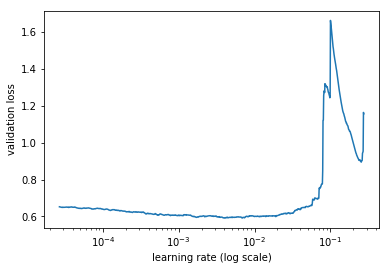

In [248]:
m.lr_find()
m.sched.plot(100)

In [249]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.584515   0.648275  
    1      0.581991   0.644481                                  
    2      0.561987   0.648007                                  



[array([0.64801])]

In [250]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.556911   0.648959  
    1      0.559229   0.649247                                  
    2      0.553605   0.651659                                  
    3      0.548378   0.650158                                  
    4      0.549682   0.653143                                  



[array([0.65314])]

In [251]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.551759   0.661161  
    1      0.540684   0.676072                                  
    2      0.541646   0.658033                                  
    3      0.54055    0.658989                                  
    4      0.545981   0.672182                                  
    5      0.533331   0.659132                                  
    6      0.52167    0.660735                                  
    7      0.524057   0.668741                                  
    8      0.527037   0.670647                                  
    9      0.515037   0.667552                                  
    10     0.506664   0.673321                                  
    11     0.505716   0.672351                                  
    12     0.515025   0.673174                                  
    13     0.501701   0.690316                                  
    14     0.499193   0.80414                            

[array([0.73555])]

In [252]:
m.save(modelName)

In [253]:
m.load(modelName)

## Validation

In [254]:
(x,y1)=m.predict_with_targs()

In [255]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2017-11-10 11:27:00,7015.000000,2017-11-10 11:27:00,0,1
2017-11-10 11:28:00,7001.509766,2017-11-10 11:28:00,0,1
2017-11-10 11:29:00,7000.000000,2017-11-10 11:29:00,0,1
2017-11-10 11:30:00,6926.020020,2017-11-10 11:30:00,0,1
2017-11-10 11:31:00,6879.979980,2017-11-10 11:31:00,1,1
2017-11-10 11:32:00,6870.330078,2017-11-10 11:32:00,1,1
2017-11-10 11:33:00,6874.560059,2017-11-10 11:33:00,1,1
2017-11-10 11:34:00,6889.279785,2017-11-10 11:34:00,1,1
2017-11-10 11:35:00,6894.529785,2017-11-10 11:35:00,1,1


Calculate the percent accuracy on the validation set

In [256]:
p.calculate_accuracy(valpred)

{'F1Score': 0.57,
 'totalAccuracy': 0.596,
 'buyAccuracy': 0.458,
 'sellAccuracy': 0.683,
 'totalBuyActions': 3878,
 'successfulBuyPredictions': 1776}

In [257]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 7287.0,
 'endClose': 6795.46,
 'startAmount': 15000,
 'endAmount': 16603.14106858913,
 'buyAndHoldPercentIncrease': -6.745,
 'percentIncrease': 10.688,
 'percentDifference': 17.433,
 'totalTrades': 1467}

In [258]:
p.plot_profit(p.net_profit_df)

In [259]:
p.net_profit_df

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-11-03 14:27:00,7287.000000,2017-11-03 14:27:00,1,1,15000.000000,0.000000
2017-11-03 14:28:00,7292.009766,2017-11-03 14:28:00,1,1,0.000000,2.057046
2017-11-03 14:29:00,7292.009766,2017-11-03 14:29:00,1,1,0.000000,2.057046
2017-11-03 14:30:00,7292.009766,2017-11-03 14:30:00,1,1,0.000000,2.057046
2017-11-03 14:31:00,7284.000000,2017-11-03 14:31:00,1,1,0.000000,2.057046
2017-11-03 14:32:00,7283.009766,2017-11-03 14:32:00,1,1,0.000000,2.057046
2017-11-03 14:33:00,7274.430176,2017-11-03 14:33:00,1,1,0.000000,2.057046
2017-11-03 14:34:00,7274.430176,2017-11-03 14:34:00,1,1,0.000000,2.057046
2017-11-03 14:35:00,7299.990234,2017-11-03 14:35:00,1,1,0.000000,2.057046


## Test

In [260]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1])

In [261]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2017-11-10 09:47:00,2017-11-10 09:47:00,7136.000000,0,1
2017-11-10 09:48:00,2017-11-10 09:48:00,7125.009766,0,1
2017-11-10 09:49:00,2017-11-10 09:49:00,7125.009766,0,1
2017-11-10 09:50:00,2017-11-10 09:50:00,7124.060059,0,1
2017-11-10 09:51:00,2017-11-10 09:51:00,7124.049805,0,1
2017-11-10 09:52:00,2017-11-10 09:52:00,7122.669922,0,1
2017-11-10 09:53:00,2017-11-10 09:53:00,7120.220215,1,1
2017-11-10 09:54:00,2017-11-10 09:54:00,7121.939941,0,1
2017-11-10 09:55:00,2017-11-10 09:55:00,7120.560059,1,1


In [262]:
p.calculate_accuracy(testPred)

{'F1Score': 0.576,
 'totalAccuracy': 0.58,
 'buyAccuracy': 0.69,
 'sellAccuracy': 0.463,
 'totalBuyActions': 5164,
 'successfulBuyPredictions': 3562}

In [263]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 7136.0,
 'endClose': 7710.04,
 'startAmount': 15000,
 'endAmount': 20049.378186818347,
 'buyAndHoldPercentIncrease': 8.044,
 'percentIncrease': 33.663,
 'percentDifference': 25.618,
 'totalTrades': 1527}

In [264]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-11-10 09:47:00,2017-11-10 09:47:00,7136.000000,0,1,15000.000000,0.000000
2017-11-10 09:48:00,2017-11-10 09:48:00,7125.009766,0,1,0.000000,2.105260
2017-11-10 09:49:00,2017-11-10 09:49:00,7125.009766,0,1,0.000000,2.105260
2017-11-10 09:50:00,2017-11-10 09:50:00,7124.060059,0,1,0.000000,2.105260
2017-11-10 09:51:00,2017-11-10 09:51:00,7124.049805,0,1,0.000000,2.105260
2017-11-10 09:52:00,2017-11-10 09:52:00,7122.669922,0,1,0.000000,2.105260
2017-11-10 09:53:00,2017-11-10 09:53:00,7120.220215,1,1,0.000000,2.105260
2017-11-10 09:54:00,2017-11-10 09:54:00,7121.939941,0,1,0.000000,2.105260
2017-11-10 09:55:00,2017-11-10 09:55:00,7120.560059,1,1,0.000000,2.105260


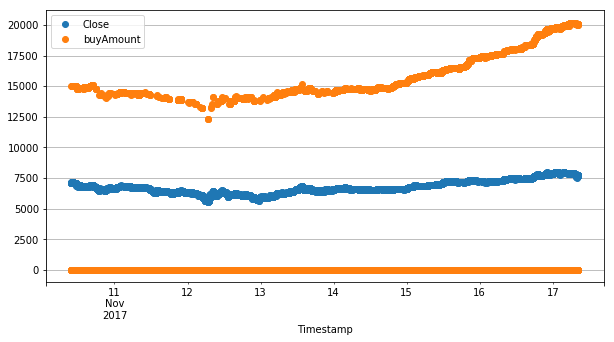

In [270]:
p.plot_profit(p.net_profit_df)